**Import Data**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -qq /content/gdrive/MyDrive/cats_vs_dogs_small_dataset.zip


Mounted at /content/gdrive


**Split Data**

In [2]:
import os, shutil, pathlib
original_dir = pathlib.Path("cats_vs_dogs_small_dataset")
new_base_dir = pathlib.Path("cats_and_dogs")

for rt, dirs, files in os.walk(original_dir):
  for file in files:
    if not file.endswith(".jpg"):
      os.remove(os.path.join(rt, file))

def make_subset(subset_name, start_index, end_index):
   for category in ("cat", "dog"):
       dir = new_base_dir / subset_name / category
       os.makedirs(dir, exist_ok=True)
       fnames = [f"{i}.jpg" for i in range(start_index, end_index)]
       for fname in fnames:
           shutil.copyfile(src=original_dir/category / fname,
                           dst=dir / fname)
make_subset("train", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=750)
make_subset("test", start_index=750, end_index=1000)

In [3]:
trainSize = len(os.listdir(new_base_dir / "train" / "cat")) +len(os.listdir(new_base_dir / "train" / "dog"))
testSize = len(os.listdir(new_base_dir / "test" / "cat")) +len(os.listdir(new_base_dir / "test" / "dog"))
valSize = len(os.listdir(new_base_dir / "validation" / "cat")) +len(os.listdir(new_base_dir / "validation" / "dog"))

print(f"Train size: {trainSize}")
print(f"Test size: {testSize}")
print(f"Validation size: {valSize}")

Train size: 1000
Test size: 500
Validation size: 500


**Preprocess data**

In [4]:
# !pip install tensorflow --upgrade
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import numpy as np

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


**Build initial model from scratch**

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Compile model**

In [6]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Run model**

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="base.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 6s 47ms/step - loss: 0.7167 - accuracy: 0.5150 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6929 - accuracy: 0.5100 - val_loss: 0.6918 - val_accuracy: 0.5380
Epoch 3/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6896 - accuracy: 0.5320 - val_loss: 0.6917 - val_accuracy: 0.5100
Epoch 4/30
32/32 [==============================] - 1s 24ms/step - loss: 0.6931 - accuracy: 0.5420 - val_loss: 0.7103 - val_accuracy: 0.5000
Epoch 5/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6787 - accuracy: 0.5860 - val_loss: 0.6670 - val_accuracy: 0.5920
Epoch 6/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6722 - accuracy: 0.6150 - val_loss: 0.6489 - val_accuracy: 0.6420
Epoch 7/30
32/32 [==============================] - 1s 24ms/step - loss: 0.6480 - accuracy: 0.6390 - val_loss: 1.0933 - val_accuracy: 0.5140
Epoch 8/30
32

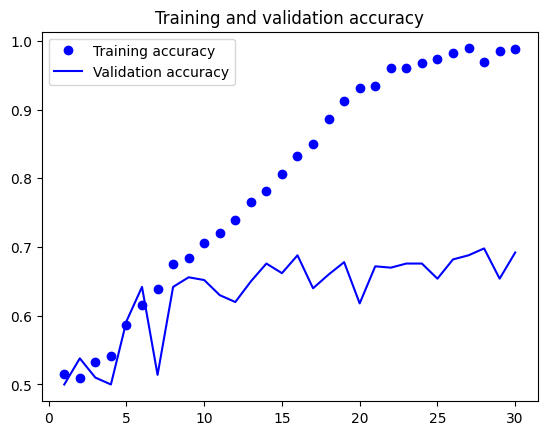

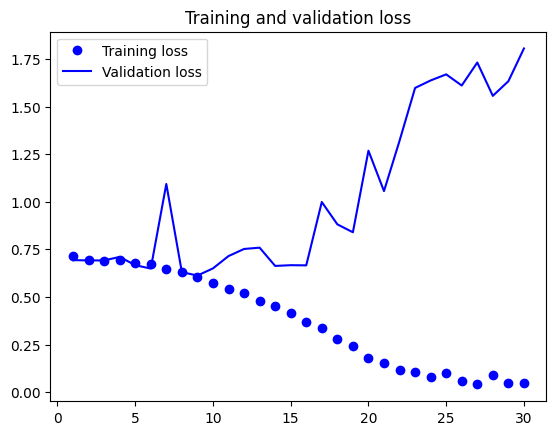

In [8]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Test Model**

In [9]:
test_model = keras.models.load_model(
    "base.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 9ms/step - loss: 0.6357 - accuracy: 0.6260
Test accuracy: 0.626


**Adding data augmentation to model**

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.4),
    ]
)

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="base_and_aug.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 2s 31ms/step - loss: 0.7223 - accuracy: 0.4870 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 1s 24ms/step - loss: 0.6932 - accuracy: 0.5100 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 1s 23ms/step - loss: 0.7381 - accuracy: 0.5580 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 4/30
32/32 [==============================] - 1s 25ms/step - loss: 0.6861 - accuracy: 0.5710 - val_loss: 0.6871 - val_accuracy: 0.5240
Epoch 5/30
32/32 [==============================] - 1s 23ms/step - loss: 0.6774 - accuracy: 0.5890 - val_loss: 1.3367 - val_accuracy: 0.5000
Epoch 6/30
32/32 [==============================] - 1s 23ms/step - loss: 0.6831 - accuracy: 0.6180 - val_loss: 1.3319 - val_accuracy: 0.5040
Epoch 7/30
32/32 [==============================] - 1s 25ms/step - loss: 0.6557 - accuracy: 0.6370 - val_loss: 0.6566 - val_accuracy: 0.5900
Epoch 8/30
32

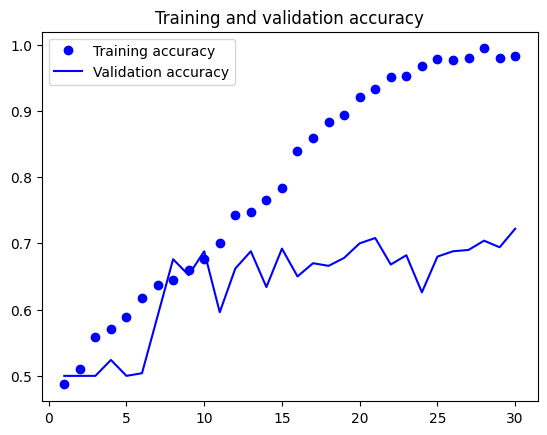

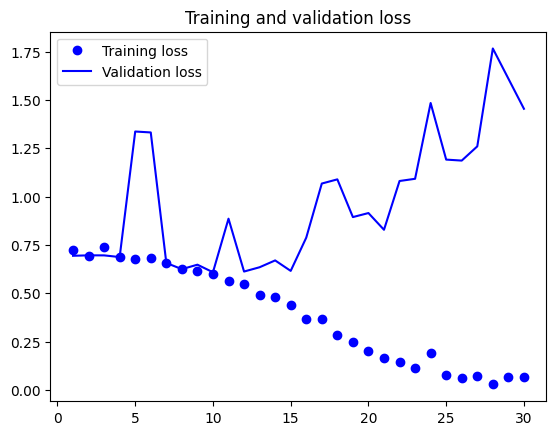

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**With data augmentation results**

In [15]:
test_model = keras.models.load_model("base_and_aug.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 10ms/step - loss: 0.6203 - accuracy: 0.6680
Test accuracy: 0.668


**Adding dropout to model**

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="base_and_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 3s 30ms/step - loss: 0.6987 - accuracy: 0.4830 - val_loss: 0.6918 - val_accuracy: 0.5080
Epoch 2/30
32/32 [==============================] - 1s 23ms/step - loss: 0.6928 - accuracy: 0.5160 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6940 - accuracy: 0.5490 - val_loss: 0.6728 - val_accuracy: 0.5800
Epoch 4/30
32/32 [==============================] - 1s 25ms/step - loss: 0.6691 - accuracy: 0.6010 - val_loss: 0.6633 - val_accuracy: 0.6000
Epoch 5/30
32/32 [==============================] - 1s 23ms/step - loss: 0.6560 - accuracy: 0.6500 - val_loss: 0.7157 - val_accuracy: 0.5780
Epoch 6/30
32/32 [==============================] - 1s 25ms/step - loss: 0.6519 - accuracy: 0.6110 - val_loss: 0.6447 - val_accuracy: 0.6380
Epoch 7/30
32/32 [==============================] - 1s 25ms/step - loss: 0.6154 - accuracy: 0.6800 - val_loss: 0.6442 - val_accuracy: 0.6180
Epoch 8/30
32

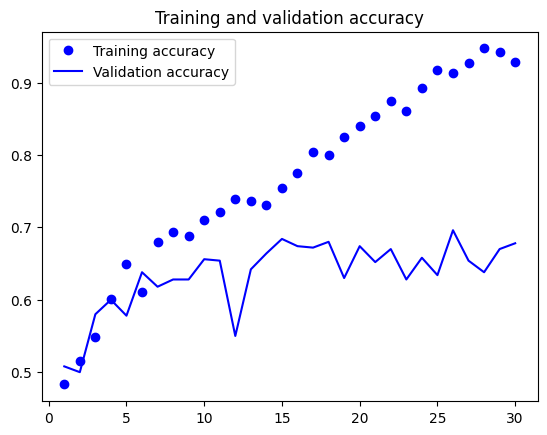

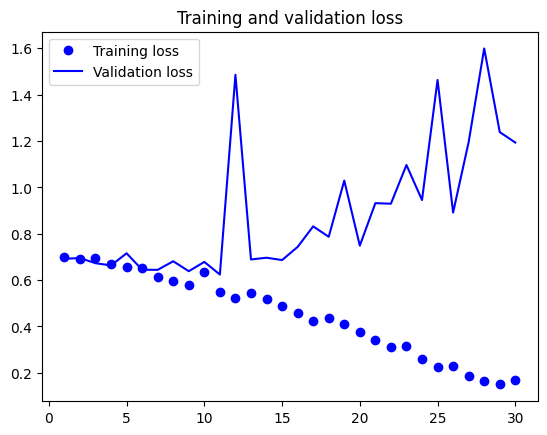

In [19]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**With dropout results**

In [20]:
test_model = keras.models.load_model("base_and_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 9ms/step - loss: 0.6213 - accuracy: 0.6580
Test accuracy: 0.658


**With data augmentation and dropout**

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.4),
    ]
)

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="base_with_aug_and_drop.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 2s 30ms/step - loss: 0.8204 - accuracy: 0.5010 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 1s 25ms/step - loss: 0.6970 - accuracy: 0.5050 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 1s 23ms/step - loss: 0.6986 - accuracy: 0.5160 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 4/30
32/32 [==============================] - 1s 25ms/step - loss: 0.6895 - accuracy: 0.5390 - val_loss: 0.6840 - val_accuracy: 0.5660
Epoch 5/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6807 - accuracy: 0.5800 - val_loss: 0.6677 - val_accuracy: 0.6060
Epoch 6/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6827 - accuracy: 0.6210 - val_loss: 0.6657 - val_accuracy: 0.6340
Epoch 7/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6603 - accuracy: 0.6250 - val_loss: 0.6501 - val_accuracy: 0.6240
Epoch 8/30
32

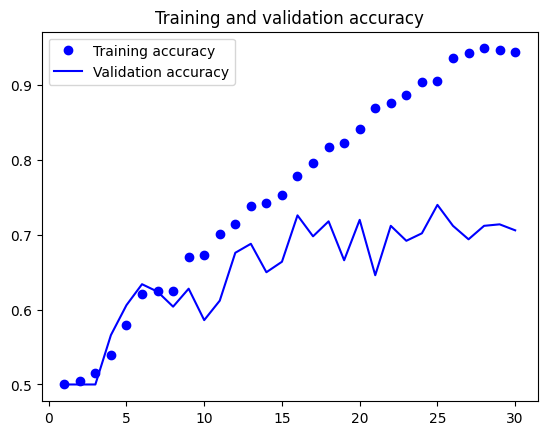

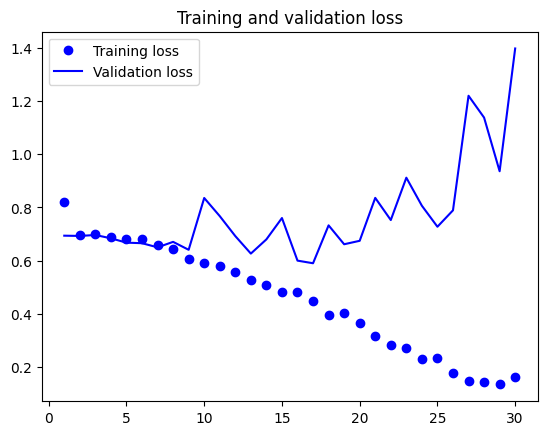

In [25]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**With data augmentation and dropout results**

In [26]:
test_model = keras.models.load_model("base_with_aug_and_drop.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 9ms/step - loss: 0.5926 - accuracy: 0.6800
Test accuracy: 0.680


**Increasing training size**

In [27]:
import os, shutil, pathlib
original_dir = pathlib.Path("cats_vs_dogs_small_dataset")
new_base_dir = pathlib.Path("cats_vs_dogs")

for rt, dirs, files in os.walk(original_dir):
  for file in files:
    if not file.endswith(".jpg"):
      os.remove(os.path.join(rt, file))

def make_subset(subset_name, start_index, end_index):
   for category in ("cat", "dog"):
       dir = new_base_dir / subset_name / category
       os.makedirs(dir, exist_ok=True)
       fnames = [f"{i}.jpg" for i in range(start_index, end_index)]
       for fname in fnames:
           shutil.copyfile(src=original_dir/category / fname,
                           dst=dir / fname)

make_subset("train", start_index=0, end_index=500)
make_subset("train", start_index=1000, end_index=1500)
make_subset("validation", start_index=500, end_index=750)
make_subset("test", start_index=750, end_index=1000)

In [28]:
trainSize = len(os.listdir(new_base_dir / "train" / "cat")) +len(os.listdir(new_base_dir / "train" / "dog"))
testSize = len(os.listdir(new_base_dir / "test" / "cat")) +len(os.listdir(new_base_dir / "test" / "dog"))
valSize = len(os.listdir(new_base_dir / "validation" / "cat")) +len(os.listdir(new_base_dir / "validation" / "dog"))

print(f"Train size: {trainSize}")
print(f"Test size: {testSize}")
print(f"Validation size: {valSize}")

Train size: 2000
Test size: 500
Validation size: 500


In [29]:
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import numpy as np

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [30]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [31]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="more_training_base.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 3s 29ms/step - loss: 0.6995 - accuracy: 0.5015 - val_loss: 0.6918 - val_accuracy: 0.5040
Epoch 2/30
63/63 [==============================] - 1s 21ms/step - loss: 0.6959 - accuracy: 0.5095 - val_loss: 0.6912 - val_accuracy: 0.5020
Epoch 3/30
63/63 [==============================] - 1s 19ms/step - loss: 0.6802 - accuracy: 0.5735 - val_loss: 0.7951 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 1s 21ms/step - loss: 0.6522 - accuracy: 0.6235 - val_loss: 0.6543 - val_accuracy: 0.6420
Epoch 5/30
63/63 [==============================] - 1s 21ms/step - loss: 0.6385 - accuracy: 0.6565 - val_loss: 0.6240 - val_accuracy: 0.6640
Epoch 6/30
63/63 [==============================] - 1s 20ms/step - loss: 0.5967 - accuracy: 0.6890 - val_loss: 0.6155 - val_accuracy: 0.6560
Epoch 7/30
63/63 [==============================] - 1s 19ms/step - loss: 0.5672 - accuracy: 0.7115 - val_loss: 0.6330 - val_accuracy: 0.6800
Epoch 8/30
63

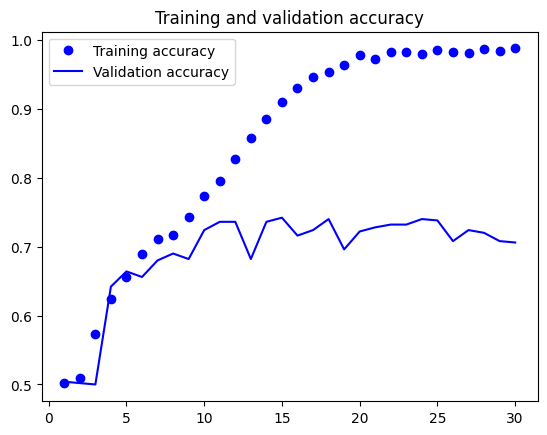

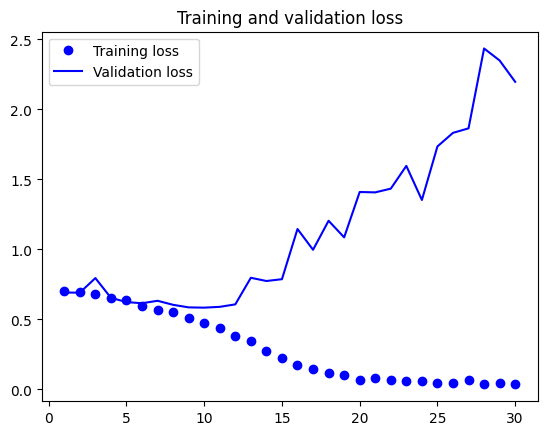

In [33]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [34]:
test_model = keras.models.load_model("more_training_base.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 9ms/step - loss: 0.6158 - accuracy: 0.7160
Test accuracy: 0.716


**Adding data augmentation**

In [35]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.4),
    ]
)

In [36]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [37]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="more_training_with_aug.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 3s 23ms/step - loss: 0.7031 - accuracy: 0.5045 - val_loss: 0.6919 - val_accuracy: 0.6220
Epoch 2/30
63/63 [==============================] - 1s 20ms/step - loss: 0.6875 - accuracy: 0.5460 - val_loss: 0.6909 - val_accuracy: 0.5320
Epoch 3/30
63/63 [==============================] - 1s 21ms/step - loss: 0.6830 - accuracy: 0.5825 - val_loss: 0.6428 - val_accuracy: 0.6460
Epoch 4/30
63/63 [==============================] - 1s 21ms/step - loss: 0.6561 - accuracy: 0.6255 - val_loss: 0.6310 - val_accuracy: 0.6540
Epoch 5/30
63/63 [==============================] - 1s 21ms/step - loss: 0.6182 - accuracy: 0.6695 - val_loss: 0.6175 - val_accuracy: 0.6720
Epoch 6/30
63/63 [==============================] - 1s 21ms/step - loss: 0.5961 - accuracy: 0.6770 - val_loss: 0.6117 - val_accuracy: 0.6980
Epoch 7/30
63/63 [==============================] - 1s 21ms/step - loss: 0.5663 - accuracy: 0.7150 - val_loss: 0.6019 - val_accuracy: 0.7000
Epoch 8/30
63

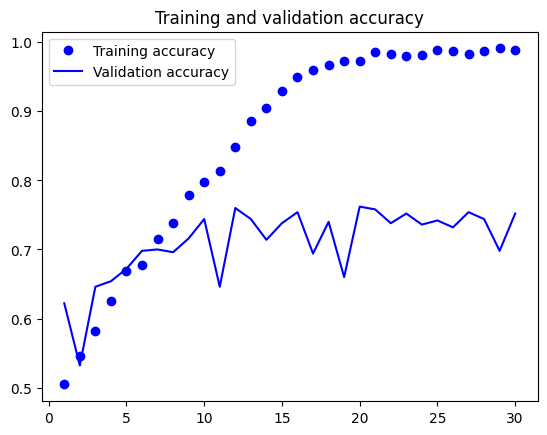

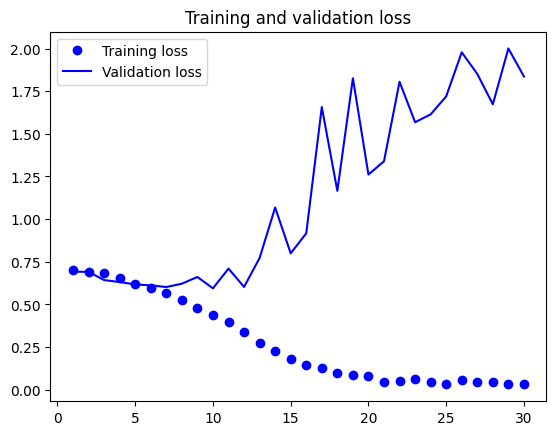

In [39]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [40]:
test_model = keras.models.load_model("more_training_with_aug.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 9ms/step - loss: 0.5799 - accuracy: 0.7340
Test accuracy: 0.734


**Using data augmentation and dropout**

In [41]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.7)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [42]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [43]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="more_training_with_aug_and_drop.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 3s 28ms/step - loss: 0.6993 - accuracy: 0.5025 - val_loss: 0.6915 - val_accuracy: 0.5020
Epoch 2/30
63/63 [==============================] - 2s 26ms/step - loss: 0.6904 - accuracy: 0.5375 - val_loss: 0.6829 - val_accuracy: 0.5400
Epoch 3/30
63/63 [==============================] - 2s 25ms/step - loss: 0.6824 - accuracy: 0.5895 - val_loss: 0.6513 - val_accuracy: 0.6280
Epoch 4/30
63/63 [==============================] - 2s 24ms/step - loss: 0.6533 - accuracy: 0.6290 - val_loss: 0.6668 - val_accuracy: 0.6020
Epoch 5/30
63/63 [==============================] - 2s 25ms/step - loss: 0.6269 - accuracy: 0.6515 - val_loss: 0.6253 - val_accuracy: 0.6600
Epoch 6/30
63/63 [==============================] - 2s 25ms/step - loss: 0.6146 - accuracy: 0.6700 - val_loss: 0.6119 - val_accuracy: 0.6760
Epoch 7/30
63/63 [==============================] - 2s 24ms/step - loss: 0.5910 - accuracy: 0.6865 - val_loss: 0.6787 - val_accuracy: 0.6440
Epoch 8/30
63

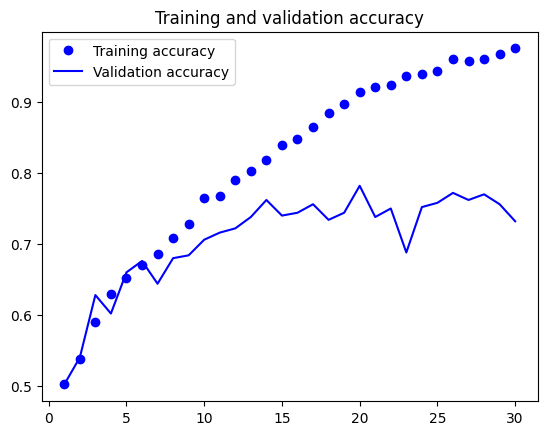

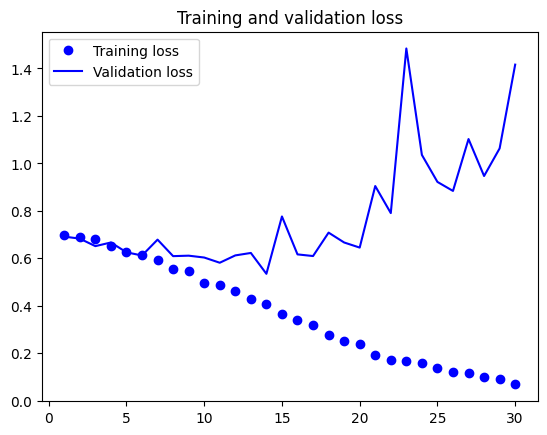

In [44]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [45]:
test_model = keras.models.load_model("more_training_with_aug_and_drop.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 10ms/step - loss: 0.5117 - accuracy: 0.7280
Test accuracy: 0.728


**Using a pretrained model**

In [46]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [47]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="pretrained_base.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 2s 27ms/step - loss: 45729.9648 - accuracy: 0.4955 - val_loss: 52257.5547 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 2s 28ms/step - loss: 24895.3008 - accuracy: 0.5270 - val_loss: 32356.6211 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 2s 28ms/step - loss: 17865.1016 - accuracy: 0.5060 - val_loss: 5811.2036 - val_accuracy: 0.5220
Epoch 4/30
63/63 [==============================] - 3s 41ms/step - loss: 10372.9902 - accuracy: 0.5285 - val_loss: 2289.5115 - val_accuracy: 0.5680
Epoch 5/30
63/63 [==============================] - 1s 13ms/step - loss: 5281.8237 - accuracy: 0.5430 - val_loss: 2769.9944 - val_accuracy: 0.5100
Epoch 6/30
63/63 [==============================] - 2s 28ms/step - loss: 2030.5228 - accuracy: 0.5175 - val_loss: 988.9367 - val_accuracy: 0.5000
Epoch 7/30
63/63 [==============================] - 2s 28ms/step - loss: 604.6912 - accuracy: 0.5035 - val_loss: 

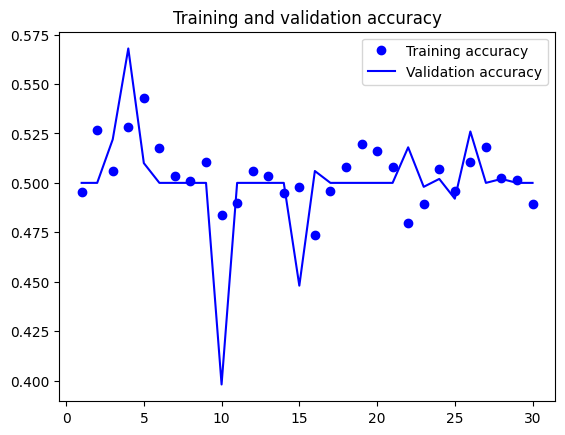

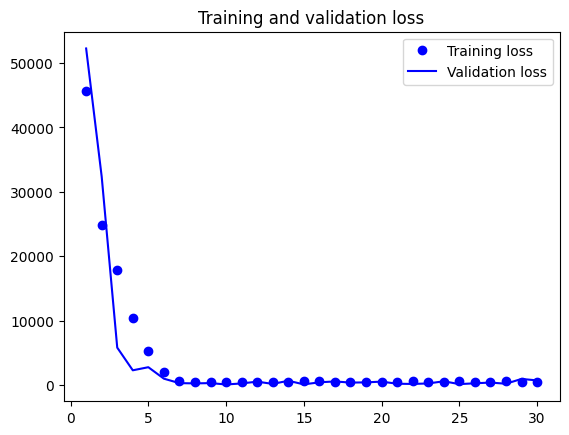

In [48]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [49]:
test_model = keras.models.load_model("pretrained_base.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 7ms/step - loss: 83.2648 - accuracy: 0.4240
Test accuracy: 0.424


**With feature extraction**

In [50]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 24ms/step


In [51]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 13.9188 - accuracy: 0.9355 - val_loss: 10.4953 - val_accuracy: 0.9420
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 4.3084 - accuracy: 0.9695 - val_loss: 7.5710 - val_accuracy: 0.9580
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 1.5712 - accuracy: 0.9885 - val_loss: 7.8892 - val_accuracy: 0.9560
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.8584 - accuracy: 0.9920 - val_loss: 7.3802 - val_accuracy: 0.9520
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.9955 - val_loss: 8.0822 - val_accuracy: 0.9580
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 0.3407 - accuracy: 0.9970 - val_loss: 19.4020 - val_accuracy: 0.9380
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 0.3633 - accuracy: 0.9965 - val_loss: 11.8616 - val_accuracy: 0.9540
Epoch 8/20
63/63

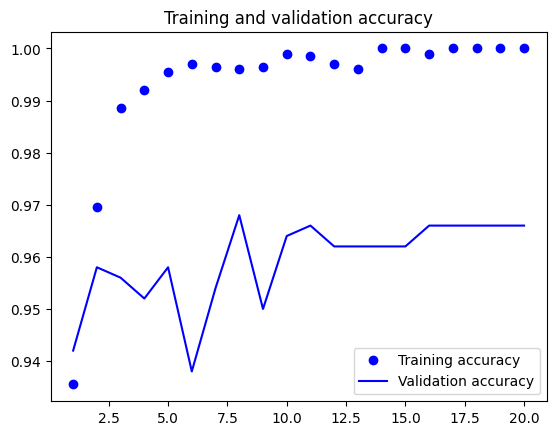

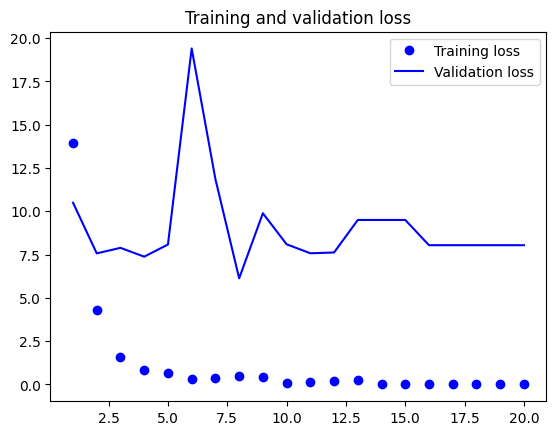

In [52]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [56]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 3ms/step - loss: 2.5719 - accuracy: 0.9820
Test accuracy: 0.982
